In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
# Chọn file kaggle.json tải về ở bước 2 để tải lên

!mkdir '/root/.kaggle'
!cp kaggle.json '/root/.kaggle'
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets list

!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

!unzip -q /content/skin-cancer-malignant-vs-benign.zip

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

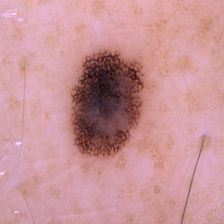

(224, 224, 3)


In [ ]:
img = cv2.imread("/content/train/benign/100.jpg")
cv2_imshow(img)
print(img.shape)

In [ ]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
# %matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms
from tqdm import tqdm

import argparse
# batch_size = 4
# num_epochs = 5
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [ ]:
import os

train_folder = "/content/train"
test_folder = "/content/test"

part = ["benign", "malignant"]
def load_image(folder):
  img = []
  y = []
  for i in part:
    data_path = os.path.join(folder, i)
    # print(str(data_path))
    for image_path in os.listdir(data_path):
      # print(type(image))
      image = cv2.imread(os.path.join(data_path, image_path))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # đưa thành ảnh RGB
      # cv2_imshow(image)
      # print(image.shape)
      # break
      img.append(image)
      y.append(i)
  return np.array(img), np.array(y)

In [ ]:
x, y = load_image(train_folder)
print(x.shape)
# print(x[1,0,:])
print(y.shape)
print(y[0])

(2637, 224, 224, 3)
(2637,)
benign


In [ ]:
def make_path(phase):
  rootpath = '/content/'
  target = os.path.join(rootpath + phase + "/*/*.jpg")

  path_list = []
  # img, y = []
  for path in glob.glob(target): # trả về list chuỗi kí tự trong * theo điều kiện trên
    path_list.append(path)
  return path_list

In [ ]:
print(len(make_path("test")))

660


/content/test/benign/394.jpg
<class 'str'>
b


[]

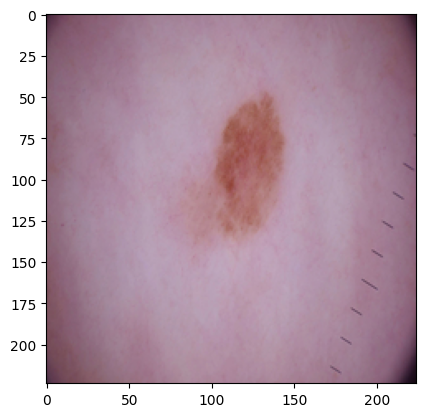

In [ ]:
img_file_path = make_path('test')
print(img_file_path[100])
print(type(img_file_path[100]))
print(img_file_path[100][14])
img = cv2.imread(img_file_path[100], cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.plot()

In [ ]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
class ImageTransform(): # đưa về tensor trong openCV
  def __init__(self, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'test': transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
        }
  def __call__(self, img, phase = 'train'):
      return self.data_transform[phase](img)


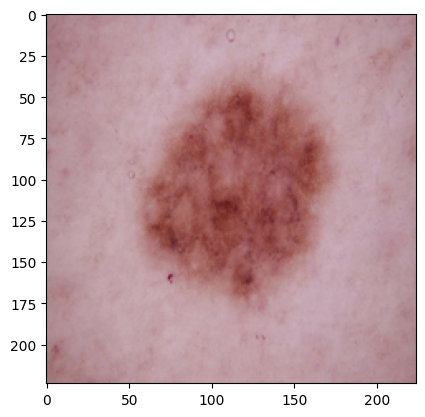

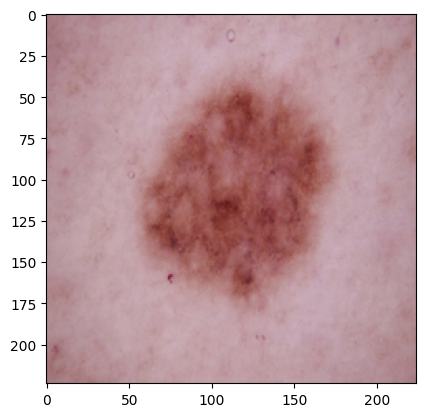

In [ ]:
img_file_path = make_path('train')
img = cv2.imread(img_file_path[100], cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

transform = ImageTransform()
img_transformed = transform(img, "train")
img_transformed = img_transformed.numpy().transpose(1, 2, 0)
plt.imshow(img_transformed)
plt.show()

In [ ]:
img_path = make_path("train")
print(img_path[:3])
label = img_path[0][15]
print(img_path[2])
print(len(img_path[2]))
print(label)

['/content/train/benign/1557.jpg', '/content/train/benign/62.jpg', '/content/train/benign/581.jpg']
/content/train/benign/581.jpg
29
b


In [ ]:
class MyDataset(data.Dataset):
  def __init__(self, file_list,transform, phase = 'train'):
    super().__init__()
    self.file_list = file_list
    self.transform = transform
    self.phase = phase
  def __len__(self):
    return len(self.file_list)

  def __getitem__(self, idx):
    img_path = self.file_list[idx]
    img = cv2.imread(img_path)
    img_transformed = self.transform(img, self.phase)

    if self.phase == "train":
      label = img_path[15]
    elif self.phase == "test":
      label = img_path[14]

    if label == 'b':
      label = 0
    elif label == 'm':
      label = 1
    return img_transformed, label

'''
init : Là hàm khởi tạo, nhận vào các tham số và khởi tạo các tham số tương ứng
len : Hàm trả về độ dài của dữ liệu
getitem: nhận vào là index, chỉ số này nằm trong độ dài của dữ liệu.
Hàm này mục tiêu để đọc dữ liệu, xử lí dữ liệu,
nhãn và trả về dữ liệu chuẩn để đưa vào model.
Các phương pháp Augmentation được thực hiện tại đây luôn.
'''

'\ninit : Là hàm khởi tạo, nhận vào các tham số và khởi tạo các tham số tương ứng\nlen : Hàm trả về độ dài của dữ liệu\ngetitem: nhận vào là index, chỉ số này nằm trong độ dài của dữ liệu.\nHàm này mục tiêu để đọc dữ liệu, xử lí dữ liệu,\nnhãn và trả về dữ liệu chuẩn để đưa vào model.\nCác phương pháp Augmentation được thực hiện tại đây luôn.\n'

In [ ]:
from torch.utils.data.dataloader import DataLoader
train_list = make_path("train")
test_list = make_path("test")
trans = ImageTransform(mean, std)
# chia dataset theo tung tap train, test
train_dataset = MyDataset(train_list, transform = trans, phase = "train")
test_dataset = MyDataset(test_list, transform = trans, phase = "test")
# index = 1
# print(train_dataset.__len__())
# img, label = train_dataset[index]
# print(img.shape)
# print(label)

print(len(train_dataset))
print(len(test_dataset))
# chia thanh cac batch de dua vao model
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
dataloader_dict = {'train': train_dataloader, 'test': test_dataloader}
print(len(dataloader_dict["train"])) # return so iterator (tong /batchsize)
print(len(dataloader_dict["train"].dataset))# return tong mau
#trả về dữ liệu theo từng batch_size
inputs, labels = next(iter(dataloader_dict['train']))
print(inputs.shape)
print(labels)

2637
660
83
2637
torch.Size([32, 3, 224, 224])
tensor([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 1, 0, 1, 1, 0, 1])


In [ ]:
print(type(dataloader_dict['train']))

<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
class Conv(torch.nn.Module):
  def __init__(self, in_features, out_features):
    super(Conv, self).__init__()
    self.conv = torch.nn.Conv2d(in_features, out_features, kernel_size = 3, stride = 1, padding = 1)
    self.norm = torch.nn.BatchNorm2d(out_features)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv(x)
    x = self.norm(x)
    x = torch.nn.functional.relu(x)
    return x

In [ ]:
class MaxPool(torch.nn.Module):
  def __init__(self):
    super(MaxPool, self).__init__()
    self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x: torch.Tensor)->torch.Tensor:
    x = self.pool(x)
    return x

In [ ]:
class Dropout(torch.nn.Dropout):
  def __init__(self, p = 0.2):
    super(Dropout, self).__init__()
    self.dropout = nn.Dropout(p)

  def forward(self, x: torch.Tensor)->torch.Tensor:
    x = self.dropout(x)
    return x

In [ ]:
class Network(torch.nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.input_norm = torch.nn.BatchNorm2d(3, affine = False)
    self.net = torch.nn.Sequential(
        Conv(3,8),
        MaxPool(),

        Conv(8, 8),
        MaxPool(),

        Conv(8, 16),
        MaxPool(),

        Conv(16, 16),
        MaxPool(),

        Conv(16, 32),
        MaxPool(),

        Conv(32, 32),
        MaxPool(),

        Conv(32, 64),
        MaxPool(),
    )
    self.func = torch.nn.Sequential(
        torch.nn.Linear(64, 32),
        Dropout(0.25),

        torch.nn.Linear(32, 16),

        torch.nn.Linear(16, 8),
        Dropout(0.2),

        torch.nn.Linear(8, 4),

        torch.nn.Linear(4, 2),
    )
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.input_norm(x)
    x = self.net(x)
    x = x.reshape(x.size(0), -1)
    x = self.func(x)
    x = torch.nn.functional.softmax(x, dim = 1)
    return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)


Device:  cuda:0


In [ ]:
net = Network().to(device)

In [ ]:
from torchsummary import summary
summary(net, (3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 3, 244, 244]               0
            Conv2d-2          [-1, 8, 244, 244]             224
       BatchNorm2d-3          [-1, 8, 244, 244]              16
              Conv-4          [-1, 8, 244, 244]               0
         MaxPool2d-5          [-1, 8, 122, 122]               0
           MaxPool-6          [-1, 8, 122, 122]               0
            Conv2d-7          [-1, 8, 122, 122]             584
       BatchNorm2d-8          [-1, 8, 122, 122]              16
              Conv-9          [-1, 8, 122, 122]               0
        MaxPool2d-10            [-1, 8, 61, 61]               0
          MaxPool-11            [-1, 8, 61, 61]               0
           Conv2d-12           [-1, 16, 61, 61]           1,168
      BatchNorm2d-13           [-1, 16, 61, 61]              32
             Conv-14           [-1, 16,

In [ ]:
!pip install tqdm

In [ ]:
save_path = '/content/drive/MyDrive/AI_Application/BTL/weight_new.pt'
def train_model(net, dataloader_dict, criterior, optimizer, num_epochs):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("Device: ", device)
  loss_train = []
  accuracy_train = []
  loss_test = []
  accuracy_test = []
  for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch, num_epochs))

    net.to(device)
    #A bool that, if True, causes cuDNN to benchmark multiple convolution algorithms and select the fastest.
    torch.backends.cudnn.benchmark = True

    for phase in ["train", "test"]:
      if phase == "train":
        net.train()
      else:
        net.eval()

      epoch_loss = 0.0
      epoch_corrects = 0

      for inputs, labels in tqdm(dataloader_dict[phase]):
        # print(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == "train"):
          outputs = net(inputs)
          loss = criterior(outputs, labels)
          _, preds = torch.max(outputs, 1) # return index cua output co xac suat la lon nhat
          if phase == 'train':
            loss.backward() # tính đạo hàm
            optimizer.step() # cập nhật vào parameter

          epoch_loss += loss.item()*inputs.size(0) #batch size .cpu().detach().numpy()
          epoch_corrects += torch.sum(preds == labels) # tong so true predicts trong 1 batch size
      epoch_loss = epoch_loss/len(dataloader_dict[phase].dataset)
      epoch_accuracy = epoch_corrects.double()/len(dataloader_dict[phase].dataset)
      print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_accuracy))
      if phase == "train":
        loss_train.append(epoch_loss)
        accuracy_train.append(epoch_accuracy.item())
      else:
        loss_test.append(epoch_loss)
        accuracy_test.append(epoch_accuracy.item())
  torch.save(net.state_dict(), save_path)
  a = list(range(0, num_epochs))
  plt.figure(figsize = (10,10))
  plt.subplot(221)
  plt.plot(a, loss_train, "b", label ="train")
  plt.plot(a, loss_test, "r", label = 'test')
  plt.legend()
  plt.xlabel('epoch')
  plt.ylabel('Loss')
  plt.title('LOSS')
  plt.plot()
  plt.subplot(222)
  plt.plot(a, accuracy_train, "b", label ="train")
  plt.plot(a, accuracy_test, "r", label = 'test')
  plt.legend()
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.title('Accuracy')
  plt.plot()

def load_model(net, model_path):
    load_weights = torch.load(model_path, map_location={"cuda:0": "cpu"})
    net.load_state_dict(load_weights)

    return net

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Device:  cuda:0
Epoch 0/100


100%|██████████| 83/83 [00:10<00:00,  7.80it/s]


train Loss: 0.6906 Acc: 0.5461


100%|██████████| 21/21 [00:02<00:00,  7.70it/s]


test Loss: 0.6890 Acc: 0.5455
Epoch 1/100


100%|██████████| 83/83 [00:10<00:00,  7.76it/s]


train Loss: 0.6878 Acc: 0.5461


100%|██████████| 21/21 [00:02<00:00,  8.55it/s]


test Loss: 0.6861 Acc: 0.5455
Epoch 2/100


100%|██████████| 83/83 [00:10<00:00,  7.77it/s]


train Loss: 0.6849 Acc: 0.5461


100%|██████████| 21/21 [00:02<00:00,  8.57it/s]


test Loss: 0.6825 Acc: 0.5455
Epoch 3/100


100%|██████████| 83/83 [00:08<00:00,  9.42it/s]


train Loss: 0.6803 Acc: 0.5465


100%|██████████| 21/21 [00:03<00:00,  5.68it/s]


test Loss: 0.6779 Acc: 0.5455
Epoch 4/100


100%|██████████| 83/83 [00:08<00:00, 10.24it/s]


train Loss: 0.6756 Acc: 0.5465


100%|██████████| 21/21 [00:03<00:00,  6.73it/s]


test Loss: 0.6707 Acc: 0.5515
Epoch 5/100


100%|██████████| 83/83 [00:09<00:00,  8.86it/s]


train Loss: 0.6694 Acc: 0.5544


100%|██████████| 21/21 [00:02<00:00,  8.56it/s]


test Loss: 0.6634 Acc: 0.5530
Epoch 6/100


100%|██████████| 83/83 [00:10<00:00,  7.79it/s]


train Loss: 0.6614 Acc: 0.5745


100%|██████████| 21/21 [00:02<00:00,  8.46it/s]


test Loss: 0.6534 Acc: 0.5879
Epoch 7/100


100%|██████████| 83/83 [00:10<00:00,  8.14it/s]


train Loss: 0.6520 Acc: 0.6109


100%|██████████| 21/21 [00:02<00:00,  8.05it/s]


test Loss: 0.6457 Acc: 0.6318
Epoch 8/100


100%|██████████| 83/83 [00:08<00:00,  9.74it/s]


train Loss: 0.6417 Acc: 0.6492


100%|██████████| 21/21 [00:04<00:00,  5.24it/s]


test Loss: 0.6311 Acc: 0.7197
Epoch 9/100


100%|██████████| 83/83 [00:08<00:00, 10.04it/s]


train Loss: 0.6313 Acc: 0.6962


100%|██████████| 21/21 [00:02<00:00,  8.06it/s]


test Loss: 0.6248 Acc: 0.7212
Epoch 10/100


100%|██████████| 83/83 [00:09<00:00,  8.38it/s]


train Loss: 0.6226 Acc: 0.7160


100%|██████████| 21/21 [00:02<00:00,  8.68it/s]


test Loss: 0.6100 Acc: 0.7561
Epoch 11/100


100%|██████████| 83/83 [00:10<00:00,  7.78it/s]


train Loss: 0.6116 Acc: 0.7357


100%|██████████| 21/21 [00:02<00:00,  8.59it/s]


test Loss: 0.5987 Acc: 0.7742
Epoch 12/100


100%|██████████| 83/83 [00:09<00:00,  8.43it/s]


train Loss: 0.5998 Acc: 0.7577


100%|██████████| 21/21 [00:02<00:00,  7.44it/s]


test Loss: 0.5871 Acc: 0.7864
Epoch 13/100


100%|██████████| 83/83 [00:08<00:00, 10.08it/s]


train Loss: 0.5920 Acc: 0.7562


100%|██████████| 21/21 [00:03<00:00,  5.27it/s]


test Loss: 0.5774 Acc: 0.7955
Epoch 14/100


100%|██████████| 83/83 [00:08<00:00,  9.68it/s]


train Loss: 0.5808 Acc: 0.7782


100%|██████████| 21/21 [00:02<00:00,  8.58it/s]


test Loss: 0.5673 Acc: 0.8030
Epoch 15/100


100%|██████████| 83/83 [00:10<00:00,  7.80it/s]


train Loss: 0.5731 Acc: 0.7736


100%|██████████| 21/21 [00:02<00:00,  8.57it/s]


test Loss: 0.5598 Acc: 0.8030
Epoch 16/100


100%|██████████| 83/83 [00:10<00:00,  7.75it/s]


train Loss: 0.5658 Acc: 0.7835


100%|██████████| 21/21 [00:02<00:00,  8.59it/s]


test Loss: 0.5489 Acc: 0.8061
Epoch 17/100


100%|██████████| 83/83 [00:09<00:00,  8.89it/s]


train Loss: 0.5573 Acc: 0.7861


100%|██████████| 21/21 [00:02<00:00,  7.02it/s]


test Loss: 0.5415 Acc: 0.8061
Epoch 18/100


100%|██████████| 83/83 [00:08<00:00,  9.90it/s]


train Loss: 0.5535 Acc: 0.7929


100%|██████████| 21/21 [00:04<00:00,  5.17it/s]


test Loss: 0.5366 Acc: 0.8167
Epoch 19/100


100%|██████████| 83/83 [00:08<00:00,  9.71it/s]


train Loss: 0.5487 Acc: 0.7827


100%|██████████| 21/21 [00:02<00:00,  8.32it/s]


test Loss: 0.5287 Acc: 0.8106
Epoch 20/100


100%|██████████| 83/83 [00:10<00:00,  8.03it/s]


train Loss: 0.5398 Acc: 0.7933


100%|██████████| 21/21 [00:02<00:00,  8.56it/s]


test Loss: 0.5245 Acc: 0.8106
Epoch 21/100


100%|██████████| 83/83 [00:10<00:00,  7.63it/s]


train Loss: 0.5333 Acc: 0.7922


100%|██████████| 21/21 [00:02<00:00,  8.52it/s]


test Loss: 0.5202 Acc: 0.8091
Epoch 22/100


100%|██████████| 83/83 [00:09<00:00,  8.51it/s]


train Loss: 0.5295 Acc: 0.7975


100%|██████████| 21/21 [00:02<00:00,  7.45it/s]


test Loss: 0.5159 Acc: 0.8091
Epoch 23/100


100%|██████████| 83/83 [00:08<00:00, 10.27it/s]


train Loss: 0.5267 Acc: 0.7998


100%|██████████| 21/21 [00:04<00:00,  5.15it/s]


test Loss: 0.5113 Acc: 0.8061
Epoch 24/100


100%|██████████| 83/83 [00:08<00:00,  9.77it/s]


train Loss: 0.5240 Acc: 0.7971


100%|██████████| 21/21 [00:02<00:00,  8.60it/s]


test Loss: 0.5079 Acc: 0.8136
Epoch 25/100


100%|██████████| 83/83 [00:10<00:00,  7.90it/s]


train Loss: 0.5201 Acc: 0.8047


100%|██████████| 21/21 [00:02<00:00,  8.66it/s]


test Loss: 0.5059 Acc: 0.8106
Epoch 26/100


100%|██████████| 83/83 [00:10<00:00,  7.70it/s]


train Loss: 0.5196 Acc: 0.8005


100%|██████████| 21/21 [00:02<00:00,  8.63it/s]


test Loss: 0.5019 Acc: 0.8136
Epoch 27/100


100%|██████████| 83/83 [00:09<00:00,  8.65it/s]


train Loss: 0.5103 Acc: 0.8074


100%|██████████| 21/21 [00:03<00:00,  6.83it/s]


test Loss: 0.5002 Acc: 0.8091
Epoch 28/100


100%|██████████| 83/83 [00:08<00:00, 10.27it/s]


train Loss: 0.5101 Acc: 0.8089


100%|██████████| 21/21 [00:04<00:00,  5.14it/s]


test Loss: 0.4976 Acc: 0.8121
Epoch 29/100


100%|██████████| 83/83 [00:08<00:00,  9.61it/s]


train Loss: 0.5108 Acc: 0.8028


100%|██████████| 21/21 [00:02<00:00,  8.84it/s]


test Loss: 0.4969 Acc: 0.8136
Epoch 30/100


100%|██████████| 83/83 [00:10<00:00,  7.75it/s]


train Loss: 0.5093 Acc: 0.8062


100%|██████████| 21/21 [00:02<00:00,  8.57it/s]


test Loss: 0.4952 Acc: 0.8121
Epoch 31/100


 19%|█▉        | 16/83 [00:53<00:15,  4.42it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79a96b17f0a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79a96b17f0a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown

train Loss: 0.5083 Acc: 0.8104


100%|██████████| 21/21 [00:02<00:00,  8.38it/s]


test Loss: 0.4956 Acc: 0.8121
Epoch 32/100


100%|██████████| 83/83 [00:10<00:00,  8.03it/s]


train Loss: 0.5027 Acc: 0.8153


100%|██████████| 21/21 [00:02<00:00,  8.12it/s]


test Loss: 0.4922 Acc: 0.8106
Epoch 33/100


100%|██████████| 83/83 [00:09<00:00,  9.16it/s]


train Loss: 0.5009 Acc: 0.8130


100%|██████████| 21/21 [00:03<00:00,  5.92it/s]


test Loss: 0.4903 Acc: 0.8106
Epoch 34/100


100%|██████████| 83/83 [00:08<00:00, 10.01it/s]


train Loss: 0.5020 Acc: 0.8081


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


test Loss: 0.4892 Acc: 0.8091
Epoch 35/100


100%|██████████| 83/83 [00:08<00:00,  9.60it/s]


train Loss: 0.4965 Acc: 0.8149


100%|██████████| 21/21 [00:02<00:00,  8.10it/s]


test Loss: 0.4879 Acc: 0.8121
Epoch 36/100


100%|██████████| 83/83 [00:10<00:00,  8.09it/s]


train Loss: 0.4988 Acc: 0.8123


100%|██████████| 21/21 [00:02<00:00,  8.21it/s]


test Loss: 0.4875 Acc: 0.8167
Epoch 37/100


100%|██████████| 83/83 [00:10<00:00,  7.90it/s]


train Loss: 0.4976 Acc: 0.8127


100%|██████████| 21/21 [00:02<00:00,  8.24it/s]


test Loss: 0.4849 Acc: 0.8167
Epoch 38/100


100%|██████████| 83/83 [00:10<00:00,  7.85it/s]


train Loss: 0.4951 Acc: 0.8146


100%|██████████| 21/21 [00:02<00:00,  8.50it/s]


test Loss: 0.4845 Acc: 0.8106
Epoch 39/100


100%|██████████| 83/83 [00:08<00:00,  9.40it/s]


train Loss: 0.4940 Acc: 0.8157


100%|██████████| 21/21 [00:03<00:00,  6.40it/s]


test Loss: 0.4826 Acc: 0.8182
Epoch 40/100


100%|██████████| 83/83 [00:08<00:00, 10.16it/s]


train Loss: 0.4921 Acc: 0.8191


100%|██████████| 21/21 [00:03<00:00,  5.57it/s]


test Loss: 0.4823 Acc: 0.8258
Epoch 41/100


100%|██████████| 83/83 [00:08<00:00,  9.60it/s]


train Loss: 0.4924 Acc: 0.8214


100%|██████████| 21/21 [00:02<00:00,  8.33it/s]


test Loss: 0.4826 Acc: 0.8167
Epoch 42/100


100%|██████████| 83/83 [00:09<00:00,  8.36it/s]


train Loss: 0.4932 Acc: 0.8195


100%|██████████| 21/21 [00:02<00:00,  8.38it/s]


test Loss: 0.4808 Acc: 0.8212
Epoch 43/100


100%|██████████| 83/83 [00:10<00:00,  7.93it/s]


train Loss: 0.4904 Acc: 0.8218


100%|██████████| 21/21 [00:02<00:00,  8.33it/s]


test Loss: 0.4799 Acc: 0.8212
Epoch 44/100


100%|██████████| 83/83 [00:10<00:00,  8.07it/s]


train Loss: 0.4890 Acc: 0.8275


100%|██████████| 21/21 [00:02<00:00,  8.40it/s]


test Loss: 0.4794 Acc: 0.8197
Epoch 45/100


100%|██████████| 83/83 [00:09<00:00,  9.10it/s]


train Loss: 0.4846 Acc: 0.8290


100%|██████████| 21/21 [00:03<00:00,  6.19it/s]


test Loss: 0.4784 Acc: 0.8212
Epoch 46/100


100%|██████████| 83/83 [00:08<00:00,  9.97it/s]


train Loss: 0.4827 Acc: 0.8312


100%|██████████| 21/21 [00:04<00:00,  4.96it/s]


test Loss: 0.4786 Acc: 0.8197
Epoch 47/100


100%|██████████| 83/83 [00:08<00:00, 10.08it/s]


train Loss: 0.4842 Acc: 0.8252


100%|██████████| 21/21 [00:02<00:00,  7.50it/s]


test Loss: 0.4776 Acc: 0.8182
Epoch 48/100


100%|██████████| 83/83 [00:09<00:00,  8.54it/s]


train Loss: 0.4827 Acc: 0.8267


100%|██████████| 21/21 [00:02<00:00,  8.40it/s]


test Loss: 0.4767 Acc: 0.8212
Epoch 49/100


100%|██████████| 83/83 [00:10<00:00,  7.96it/s]


train Loss: 0.4838 Acc: 0.8271


100%|██████████| 21/21 [00:02<00:00,  8.48it/s]


test Loss: 0.4780 Acc: 0.8212
Epoch 50/100


100%|██████████| 83/83 [00:10<00:00,  8.01it/s]


train Loss: 0.4814 Acc: 0.8248


100%|██████████| 21/21 [00:02<00:00,  7.95it/s]


test Loss: 0.4772 Acc: 0.8242
Epoch 51/100


100%|██████████| 83/83 [00:09<00:00,  8.71it/s]


train Loss: 0.4820 Acc: 0.8263


100%|██████████| 21/21 [00:02<00:00,  7.36it/s]


test Loss: 0.4748 Acc: 0.8242
Epoch 52/100


100%|██████████| 83/83 [00:08<00:00, 10.29it/s]


train Loss: 0.4767 Acc: 0.8339


100%|██████████| 21/21 [00:04<00:00,  4.99it/s]


test Loss: 0.4751 Acc: 0.8303
Epoch 53/100


100%|██████████| 83/83 [00:08<00:00,  9.86it/s]


train Loss: 0.4799 Acc: 0.8312


100%|██████████| 21/21 [00:02<00:00,  7.41it/s]


test Loss: 0.4740 Acc: 0.8303
Epoch 54/100


100%|██████████| 83/83 [00:10<00:00,  8.29it/s]


train Loss: 0.4780 Acc: 0.8331


100%|██████████| 21/21 [00:02<00:00,  8.04it/s]


test Loss: 0.4739 Acc: 0.8288
Epoch 55/100


100%|██████████| 83/83 [00:10<00:00,  7.78it/s]


train Loss: 0.4746 Acc: 0.8358


100%|██████████| 21/21 [00:02<00:00,  7.52it/s]


test Loss: 0.4729 Acc: 0.8288
Epoch 56/100


100%|██████████| 83/83 [00:11<00:00,  7.46it/s]


train Loss: 0.4721 Acc: 0.8434


100%|██████████| 21/21 [00:02<00:00,  8.11it/s]


test Loss: 0.4721 Acc: 0.8288
Epoch 57/100


100%|██████████| 83/83 [00:10<00:00,  8.06it/s]


train Loss: 0.4720 Acc: 0.8392


100%|██████████| 21/21 [00:02<00:00,  8.46it/s]


test Loss: 0.4700 Acc: 0.8348
Epoch 58/100


100%|██████████| 83/83 [00:08<00:00,  9.41it/s]


train Loss: 0.4729 Acc: 0.8426


100%|██████████| 21/21 [00:03<00:00,  6.31it/s]


test Loss: 0.4704 Acc: 0.8379
Epoch 59/100


100%|██████████| 83/83 [00:08<00:00, 10.34it/s]


train Loss: 0.4690 Acc: 0.8422


100%|██████████| 21/21 [00:03<00:00,  5.94it/s]


test Loss: 0.4698 Acc: 0.8379
Epoch 60/100


100%|██████████| 83/83 [00:08<00:00,  9.44it/s]


train Loss: 0.4731 Acc: 0.8396


100%|██████████| 21/21 [00:02<00:00,  8.49it/s]


test Loss: 0.4690 Acc: 0.8348
Epoch 61/100


100%|██████████| 83/83 [00:10<00:00,  8.18it/s]


train Loss: 0.4694 Acc: 0.8445


100%|██████████| 21/21 [00:02<00:00,  8.53it/s]


test Loss: 0.4689 Acc: 0.8348
Epoch 62/100


100%|██████████| 83/83 [00:10<00:00,  8.02it/s]


train Loss: 0.4674 Acc: 0.8445


100%|██████████| 21/21 [00:02<00:00,  8.57it/s]


test Loss: 0.4694 Acc: 0.8364
Epoch 63/100


100%|██████████| 83/83 [00:09<00:00,  8.32it/s]


train Loss: 0.4667 Acc: 0.8422


100%|██████████| 21/21 [00:02<00:00,  8.09it/s]


test Loss: 0.4689 Acc: 0.8303
Epoch 64/100


100%|██████████| 83/83 [00:08<00:00, 10.20it/s]


train Loss: 0.4636 Acc: 0.8479


100%|██████████| 21/21 [00:04<00:00,  5.19it/s]


test Loss: 0.4669 Acc: 0.8394
Epoch 65/100


100%|██████████| 83/83 [00:08<00:00, 10.30it/s]


train Loss: 0.4644 Acc: 0.8453


100%|██████████| 21/21 [00:02<00:00,  7.59it/s]


test Loss: 0.4664 Acc: 0.8379
Epoch 66/100


100%|██████████| 83/83 [00:09<00:00,  8.81it/s]


train Loss: 0.4616 Acc: 0.8506


100%|██████████| 21/21 [00:02<00:00,  8.53it/s]


test Loss: 0.4680 Acc: 0.8409
Epoch 67/100


100%|██████████| 83/83 [00:10<00:00,  8.12it/s]


train Loss: 0.4640 Acc: 0.8536


100%|██████████| 21/21 [00:02<00:00,  8.67it/s]


test Loss: 0.4665 Acc: 0.8348
Epoch 68/100


100%|██████████| 83/83 [00:10<00:00,  8.04it/s]


train Loss: 0.4597 Acc: 0.8487


100%|██████████| 21/21 [00:02<00:00,  8.63it/s]


test Loss: 0.4675 Acc: 0.8333
Epoch 69/100


100%|██████████| 83/83 [00:08<00:00,  9.30it/s]


train Loss: 0.4627 Acc: 0.8491


100%|██████████| 21/21 [00:03<00:00,  6.90it/s]


test Loss: 0.4661 Acc: 0.8394
Epoch 70/100


100%|██████████| 83/83 [00:08<00:00, 10.30it/s]


train Loss: 0.4658 Acc: 0.8445


100%|██████████| 21/21 [00:03<00:00,  5.27it/s]


test Loss: 0.4663 Acc: 0.8394
Epoch 71/100


100%|██████████| 83/83 [00:08<00:00,  9.96it/s]


train Loss: 0.4593 Acc: 0.8510


100%|██████████| 21/21 [00:02<00:00,  8.56it/s]


test Loss: 0.4661 Acc: 0.8394
Epoch 72/100


100%|██████████| 83/83 [00:09<00:00,  8.35it/s]


train Loss: 0.4625 Acc: 0.8487


100%|██████████| 21/21 [00:02<00:00,  8.59it/s]


test Loss: 0.4648 Acc: 0.8348
Epoch 73/100


100%|██████████| 83/83 [00:10<00:00,  8.16it/s]


train Loss: 0.4583 Acc: 0.8513


100%|██████████| 21/21 [00:02<00:00,  8.62it/s]


test Loss: 0.4641 Acc: 0.8409
Epoch 74/100


100%|██████████| 83/83 [00:09<00:00,  8.83it/s]


train Loss: 0.4596 Acc: 0.8498


100%|██████████| 21/21 [00:02<00:00,  7.57it/s]


test Loss: 0.4665 Acc: 0.8348
Epoch 75/100


100%|██████████| 83/83 [00:07<00:00, 10.38it/s]


train Loss: 0.4586 Acc: 0.8517


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


test Loss: 0.4656 Acc: 0.8424
Epoch 76/100


100%|██████████| 83/83 [00:08<00:00,  9.97it/s]


train Loss: 0.4567 Acc: 0.8559


100%|██████████| 21/21 [00:02<00:00,  8.63it/s]


test Loss: 0.4637 Acc: 0.8348
Epoch 77/100


100%|██████████| 83/83 [00:10<00:00,  8.23it/s]


train Loss: 0.4524 Acc: 0.8635


100%|██████████| 21/21 [00:02<00:00,  8.62it/s]


test Loss: 0.4635 Acc: 0.8364
Epoch 78/100


100%|██████████| 83/83 [00:10<00:00,  8.02it/s]


train Loss: 0.4566 Acc: 0.8593


100%|██████████| 21/21 [00:02<00:00,  8.42it/s]


test Loss: 0.4632 Acc: 0.8364
Epoch 79/100


100%|██████████| 83/83 [00:09<00:00,  8.46it/s]


train Loss: 0.4493 Acc: 0.8620


100%|██████████| 21/21 [00:02<00:00,  7.79it/s]


test Loss: 0.4648 Acc: 0.8364
Epoch 80/100


100%|██████████| 83/83 [00:08<00:00, 10.26it/s]


train Loss: 0.4540 Acc: 0.8532


100%|██████████| 21/21 [00:04<00:00,  5.02it/s]


test Loss: 0.4663 Acc: 0.8258
Epoch 81/100


100%|██████████| 83/83 [00:08<00:00, 10.23it/s]


train Loss: 0.4512 Acc: 0.8616


100%|██████████| 21/21 [00:03<00:00,  6.72it/s]


test Loss: 0.4633 Acc: 0.8424
Epoch 82/100


100%|██████████| 83/83 [00:09<00:00,  8.65it/s]


train Loss: 0.4534 Acc: 0.8559


100%|██████████| 21/21 [00:02<00:00,  8.20it/s]


test Loss: 0.4614 Acc: 0.8348
Epoch 83/100


100%|██████████| 83/83 [00:10<00:00,  7.73it/s]


train Loss: 0.4521 Acc: 0.8608


100%|██████████| 21/21 [00:02<00:00,  8.27it/s]


test Loss: 0.4623 Acc: 0.8258
Epoch 84/100


100%|██████████| 83/83 [00:10<00:00,  7.90it/s]


train Loss: 0.4500 Acc: 0.8612


100%|██████████| 21/21 [00:02<00:00,  8.24it/s]


test Loss: 0.4609 Acc: 0.8333
Epoch 85/100


100%|██████████| 83/83 [00:10<00:00,  7.99it/s]


train Loss: 0.4506 Acc: 0.8642


100%|██████████| 21/21 [00:02<00:00,  7.72it/s]


test Loss: 0.4619 Acc: 0.8333
Epoch 86/100


100%|██████████| 83/83 [00:09<00:00,  8.89it/s]


train Loss: 0.4465 Acc: 0.8677


100%|██████████| 21/21 [00:03<00:00,  6.62it/s]


test Loss: 0.4616 Acc: 0.8364
Epoch 87/100


100%|██████████| 83/83 [00:08<00:00,  9.80it/s]


train Loss: 0.4448 Acc: 0.8688


100%|██████████| 21/21 [00:04<00:00,  4.99it/s]


test Loss: 0.4598 Acc: 0.8348
Epoch 88/100


100%|██████████| 83/83 [00:08<00:00,  9.83it/s]


train Loss: 0.4459 Acc: 0.8680


100%|██████████| 21/21 [00:03<00:00,  6.07it/s]


test Loss: 0.4589 Acc: 0.8379
Epoch 89/100


100%|██████████| 83/83 [00:08<00:00,  9.31it/s]


train Loss: 0.4482 Acc: 0.8669


100%|██████████| 21/21 [00:02<00:00,  8.48it/s]


test Loss: 0.4600 Acc: 0.8273
Epoch 90/100


100%|██████████| 83/83 [00:10<00:00,  8.11it/s]


train Loss: 0.4425 Acc: 0.8707


100%|██████████| 21/21 [00:02<00:00,  8.13it/s]


test Loss: 0.4575 Acc: 0.8424
Epoch 91/100


100%|██████████| 83/83 [00:10<00:00,  8.10it/s]


train Loss: 0.4408 Acc: 0.8741


100%|██████████| 21/21 [00:02<00:00,  8.37it/s]


test Loss: 0.4601 Acc: 0.8379
Epoch 92/100


100%|██████████| 83/83 [00:09<00:00,  8.61it/s]


train Loss: 0.4461 Acc: 0.8673


100%|██████████| 21/21 [00:02<00:00,  7.69it/s]


test Loss: 0.4573 Acc: 0.8364
Epoch 93/100


100%|██████████| 83/83 [00:08<00:00,  9.98it/s]


train Loss: 0.4415 Acc: 0.8677


100%|██████████| 21/21 [00:03<00:00,  5.28it/s]


test Loss: 0.4595 Acc: 0.8379
Epoch 94/100


100%|██████████| 83/83 [00:08<00:00, 10.26it/s]


train Loss: 0.4400 Acc: 0.8699


100%|██████████| 21/21 [00:03<00:00,  6.73it/s]


test Loss: 0.4596 Acc: 0.8303
Epoch 95/100


100%|██████████| 83/83 [00:09<00:00,  9.15it/s]


train Loss: 0.4361 Acc: 0.8760


100%|██████████| 21/21 [00:02<00:00,  7.87it/s]


test Loss: 0.4574 Acc: 0.8379
Epoch 96/100


100%|██████████| 83/83 [00:10<00:00,  8.15it/s]


train Loss: 0.4378 Acc: 0.8737


100%|██████████| 21/21 [00:02<00:00,  8.43it/s]


test Loss: 0.4574 Acc: 0.8409
Epoch 97/100


100%|██████████| 83/83 [00:10<00:00,  8.22it/s]


train Loss: 0.4361 Acc: 0.8786


100%|██████████| 21/21 [00:02<00:00,  8.51it/s]


test Loss: 0.4557 Acc: 0.8379
Epoch 98/100


100%|██████████| 83/83 [00:09<00:00,  8.85it/s]


train Loss: 0.4357 Acc: 0.8756


100%|██████████| 21/21 [00:02<00:00,  7.45it/s]


test Loss: 0.4563 Acc: 0.8439
Epoch 99/100


100%|██████████| 83/83 [00:08<00:00, 10.24it/s]


train Loss: 0.4390 Acc: 0.8752


100%|██████████| 21/21 [00:04<00:00,  5.02it/s]


test Loss: 0.4562 Acc: 0.8439


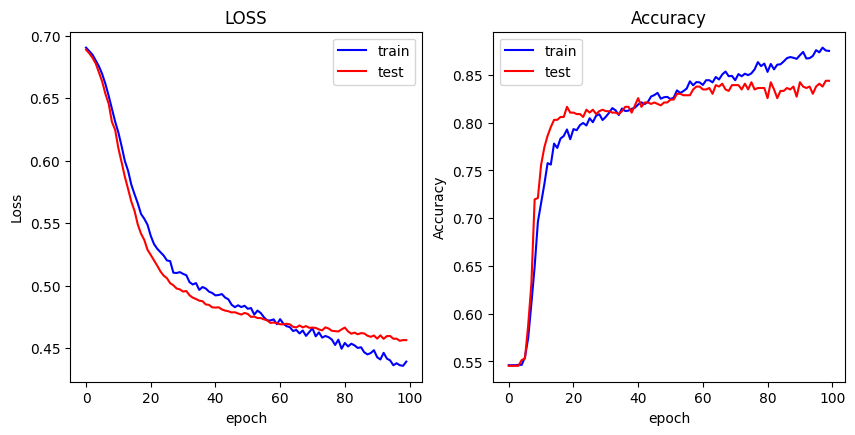

In [ ]:
#https://androidkt.com/where-should-place-dropout-batch-normalization-and-activation-layer/
num_epochs = 100
def main():
  train_list = make_path("train")
  test_list = make_path("test")
  # chia dataset theo tung tap train, test
  train_dataset = MyDataset(train_list, transform = ImageTransform(mean, std), phase = "train")
  test_dataset = MyDataset(test_list, transform = ImageTransform(mean, std), phase = "test")

  # chia thanh cac batch de dua vao model
  batch_size = 32
  train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers=10)
  test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers=10)
  dataloader_dict = {'train': train_dataloader, 'test': test_dataloader}

  net = Network()
  criterior = torch.nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr = 1e-5)
  train_model(net, dataloader_dict, criterior, optimizer, num_epochs)

if __name__ == "__main__":

    main()

In [ ]:
class_index = ["benign", "malignant"]

class Predictor():
    def __init__(self, class_index):
        self.clas_index = class_index

    def predict_max(self, output): # [0.9, 0.1]
        max_id = np.argmax(output.detach().numpy())
        predicted_label = self.clas_index[max_id]
        return predicted_label


predictor = Predictor(class_index)

def predict(img):
    # prepare network
    # use_pretrained = True
    net = Network()
    net.eval()

    # prepare model
    model = load_model(net, save_path)

    # prepare input img
    transform = ImageTransform(mean, std)
    img = transform(img, phase="test")
    img = img.unsqueeze(0) # (chan, height, width) -> (1, chan, height, width)

    # predict
    output = model(img)
    response = predictor.predict_max(output)

    return response

In [ ]:
# predict new image
img = cv2.imread('/content/malignant1.png')
img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
print(img.shape)
predict(img)

(224, 224, 3)


'malignant'

USING PRE-TRAINED MODEL BY VGG16

In [ ]:
def params_to_update(net):
    params_to_update_1 = []
    params_to_update_2 = []
    params_to_update_3 = []

    update_param_name_1 = ["features"]
    update_param_name_2 = ["classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
    update_param_name_3 = ["classifier.6.weight", "classifier.6.bias"]

    for name, param in net.named_parameters():
        if name in update_param_name_1:
            param.requires_grad = True
            params_to_update_1.append(param)
        elif name in update_param_name_2:
            param.requires_grad = True
            params_to_update_2.append(param)
        elif name in update_param_name_3:
            param.requires_grad = True
            params_to_update_3.append(param)

        else:
            param.requires_grad = False
    return params_to_update_1, params_to_update_2, params_to_update_3

In [ ]:
save_path = '/content/drive/MyDrive/Image_Processing/weight_vgg16.pt'
def train_model_vgg16(net, dataloader_dict, criterior, optimizer, num_epochs):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("Device: ", device)
  loss_train = []
  accuracy_train = []
  loss_test = []
  accuracy_test = []
  for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch, num_epochs))

    net.to(device)
    #A bool that, if True, causes cuDNN to benchmark multiple convolution algorithms and select the fastest.
    torch.backends.cudnn.benchmark = True

    for phase in ["train", "test"]:
      if phase == "train":
        net.train()
      else:
        net.eval()

      epoch_loss = 0.0
      epoch_corrects = 0

      for inputs, labels in tqdm(dataloader_dict[phase]):
        # print(labels)
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == "train"):
          outputs = net(inputs)
          loss = criterior(outputs, labels)
          _, preds = torch.max(outputs, 1) # return index cua output co xac suat la lon nhat
          if phase == 'train':
            loss.backward() # tính đạo hàm
            optimizer.step() # cập nhật vào parameter

          epoch_loss += loss.item()*inputs.size(0) #batch size
          epoch_corrects += torch.sum(preds == labels).detach().cpu().numpy() # tong so true predicts trong 1 batch size
      epoch_loss = epoch_loss/len(dataloader_dict[phase].dataset)
      epoch_accuracy = float(epoch_corrects)/len(dataloader_dict[phase].dataset)
      print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_accuracy))
      if phase == "train":
        loss_train.append(epoch_loss)
        accuracy_train.append(epoch_accuracy)
      else:
        loss_test.append(epoch_loss)
        accuracy_test.append(epoch_accuracy)
  torch.save(net.state_dict(), save_path)
  a = list(range(0, num_epochs))
  plt.figure(figsize = (10,10))
  plt.subplot(221)
  plt.plot(a, loss_train, "b", label ="train")
  plt.plot(a, loss_test, "r", label = 'test')
  plt.legend()
  plt.xlabel('epoch')
  plt.ylabel('Loss')
  plt.title('LOSS')
  plt.plot()
  plt.subplot(222)
  plt.plot(a, accuracy_train, "b", label ="train")
  plt.plot(a, accuracy_test, "r", label = 'test')
  plt.legend()
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.title('Accuracy')
  plt.plot()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device:  cuda:0
Epoch 0/20


100%|██████████| 83/83 [00:18<00:00,  4.38it/s]


train Loss: 0.5042 Acc: 0.7425


100%|██████████| 21/21 [00:04<00:00,  4.40it/s]


test Loss: 0.3875 Acc: 0.8348
Epoch 1/20


100%|██████████| 83/83 [00:19<00:00,  4.33it/s]


train Loss: 0.4082 Acc: 0.8100


100%|██████████| 21/21 [00:04<00:00,  4.83it/s]


test Loss: 0.3772 Acc: 0.8227
Epoch 2/20


100%|██████████| 83/83 [00:20<00:00,  4.07it/s]


train Loss: 0.3664 Acc: 0.8354


100%|██████████| 21/21 [00:04<00:00,  4.86it/s]


test Loss: 0.3672 Acc: 0.8167
Epoch 3/20


100%|██████████| 83/83 [00:19<00:00,  4.30it/s]


train Loss: 0.3482 Acc: 0.8403


100%|██████████| 21/21 [00:04<00:00,  4.33it/s]


test Loss: 0.3624 Acc: 0.8167
Epoch 4/20


100%|██████████| 83/83 [00:19<00:00,  4.34it/s]


train Loss: 0.3330 Acc: 0.8434


100%|██████████| 21/21 [00:04<00:00,  4.72it/s]


test Loss: 0.3541 Acc: 0.8333
Epoch 5/20


100%|██████████| 83/83 [00:19<00:00,  4.26it/s]


train Loss: 0.3144 Acc: 0.8589


100%|██████████| 21/21 [00:04<00:00,  4.85it/s]


test Loss: 0.3471 Acc: 0.8288
Epoch 6/20


100%|██████████| 83/83 [00:19<00:00,  4.24it/s]


train Loss: 0.3030 Acc: 0.8586


100%|██████████| 21/21 [00:04<00:00,  4.71it/s]


test Loss: 0.3487 Acc: 0.8242
Epoch 7/20


100%|██████████| 83/83 [00:19<00:00,  4.31it/s]


train Loss: 0.2939 Acc: 0.8692


100%|██████████| 21/21 [00:04<00:00,  4.44it/s]


test Loss: 0.3462 Acc: 0.8333
Epoch 8/20


100%|██████████| 83/83 [00:19<00:00,  4.22it/s]


train Loss: 0.2819 Acc: 0.8768


100%|██████████| 21/21 [00:04<00:00,  4.87it/s]


test Loss: 0.3400 Acc: 0.8258
Epoch 9/20


100%|██████████| 83/83 [00:19<00:00,  4.22it/s]


train Loss: 0.2658 Acc: 0.8893


100%|██████████| 21/21 [00:04<00:00,  4.84it/s]


test Loss: 0.3436 Acc: 0.8303
Epoch 10/20


100%|██████████| 83/83 [00:19<00:00,  4.30it/s]


train Loss: 0.2485 Acc: 0.8885


100%|██████████| 21/21 [00:04<00:00,  4.54it/s]


test Loss: 0.3323 Acc: 0.8258
Epoch 11/20


100%|██████████| 83/83 [00:19<00:00,  4.34it/s]


train Loss: 0.2467 Acc: 0.8874


100%|██████████| 21/21 [00:04<00:00,  4.61it/s]


test Loss: 0.3407 Acc: 0.8227
Epoch 12/20


100%|██████████| 83/83 [00:19<00:00,  4.29it/s]


train Loss: 0.2324 Acc: 0.8991


100%|██████████| 21/21 [00:04<00:00,  4.87it/s]


test Loss: 0.3406 Acc: 0.8227
Epoch 13/20


100%|██████████| 83/83 [00:19<00:00,  4.17it/s]


train Loss: 0.2243 Acc: 0.9018


100%|██████████| 21/21 [00:04<00:00,  4.30it/s]


test Loss: 0.3407 Acc: 0.8379
Epoch 14/20


100%|██████████| 83/83 [00:19<00:00,  4.34it/s]


train Loss: 0.2219 Acc: 0.9010


100%|██████████| 21/21 [00:04<00:00,  4.57it/s]


test Loss: 0.3413 Acc: 0.8348
Epoch 15/20


100%|██████████| 83/83 [00:19<00:00,  4.29it/s]


train Loss: 0.2027 Acc: 0.9132


100%|██████████| 21/21 [00:04<00:00,  4.86it/s]


test Loss: 0.3495 Acc: 0.8318
Epoch 16/20


100%|██████████| 83/83 [00:19<00:00,  4.22it/s]


train Loss: 0.1943 Acc: 0.9192


100%|██████████| 21/21 [00:04<00:00,  4.87it/s]


test Loss: 0.3394 Acc: 0.8379
Epoch 17/20


100%|██████████| 83/83 [00:19<00:00,  4.32it/s]


train Loss: 0.1888 Acc: 0.9185


100%|██████████| 21/21 [00:04<00:00,  4.37it/s]


test Loss: 0.3443 Acc: 0.8424
Epoch 18/20


100%|██████████| 83/83 [00:19<00:00,  4.34it/s]


train Loss: 0.1663 Acc: 0.9302


100%|██████████| 21/21 [00:04<00:00,  4.80it/s]


test Loss: 0.3563 Acc: 0.8303
Epoch 19/20


100%|██████████| 83/83 [00:20<00:00,  4.13it/s]


train Loss: 0.1739 Acc: 0.9245


100%|██████████| 21/21 [00:04<00:00,  4.83it/s]


test Loss: 0.3498 Acc: 0.8348


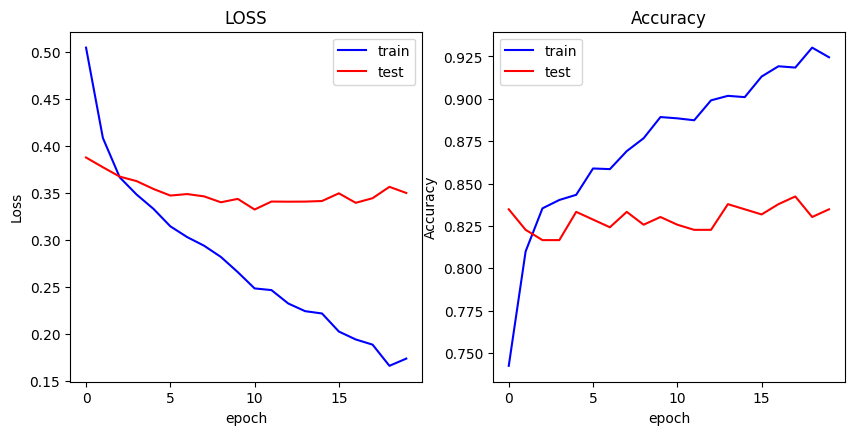

In [ ]:
num_epochs = 20
def main():
  train_list = make_path("train")
  test_list = make_path("test")
  # chia dataset theo tung tap train, test
  train_dataset = MyDataset(train_list, transform = ImageTransform(), phase = "train")
  test_dataset = MyDataset(test_list, transform = ImageTransform(), phase = "test")

  # chia thanh cac batch de dua vao model
  batch_size = 32
  train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
  test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
  dataloader_dict = {'train': train_dataloader, 'test': test_dataloader}

  net = models.vgg16(pretrained = True)
  net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

  criterior = nn.CrossEntropyLoss()
  params1, params2, params3 = params_to_update(net)
  optimizer = optim.SGD([
        {'params': params1, 'lr': 1e-4},
        {'params': params2, 'lr': 5e-4},
        {'params': params3, 'lr': 1e-3},
    ], momentum=0.9)
  train_model_vgg16(net, dataloader_dict, criterior, optimizer, num_epochs)


if __name__ == "__main__":

    main()

In [ ]:
class_index = ["benign", "malignant"]

class Predictor():
    def __init__(self, class_index):
        self.clas_index = class_index

    def predict_max(self, output): # [0.9, 0.1]
        max_id = np.argmax(output.detach().numpy())
        predicted_label = self.clas_index[max_id]
        return predicted_label


predictor = Predictor(class_index)

def predict(img):
    # prepare network
    use_pretrained = True
    net = models.vgg16(pretrained=use_pretrained)
    net.classifier[6] = nn.Linear(in_features=4096, out_features=2)
    net.eval()

    # prepare model
    model = load_model(net, save_path)

    # prepare input img
    transform = ImageTransform()
    img = transform(img, phase="test")
    img = img.unsqueeze_(0) # (chan, height, width) -> (1, chan, height, width)

    # predict
    output = model(img)
    response = predictor.predict_max(output)

    return response

In [ ]:
# predict new image
img = cv2.imread('/content/malignant1.png')
img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
print(img.shape)
predict(img)

(224, 224, 3)


'malignant'